In [1]:
%load_ext autoreload
%autoreload 2

import os

os.chdir('/data/core-rad/tobweber/bernoulli-mri')

import torch
from torch.utils.data import DataLoader
from src.datasets import BrainDataset
from monai.metrics import DiceMetric, MeanIoU
from monai.networks.nets import UNet
from monai.networks import one_hot
from src.distribution import SoftBernoulliSampler
from src.utils import ifft2c
import matplotlib.pyplot as plt
from src.utils import get_top_k_mask, convert_brats_labels

# BraTS

In [2]:
ds = BrainDataset('/data/core-rad/data/Task01_BrainTumour', train=False)
dl = DataLoader(ds, batch_size=64, num_workers=64, persistent_workers=True)

model = UNet(
        spatial_dims=2,
        in_channels=4,
        out_channels=4,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2
    ).cuda()


sd = torch.load('models/brain_base.pt')
model.load_state_dict(sd['model'])

model.eval()
for p in model.parameters():
    p.requires_grad = False

dice_metric = DiceMetric(include_background=False, reduction='none', ignore_empty=False)
iou_metric = MeanIoU(include_background=False, reduction='none', ignore_empty=False)

sampler = SoftBernoulliSampler()

r = {}

## Fully Sampled

In [3]:
for batch in dl:
        img = batch['img'].cuda()
        seg = batch['seg'].cuda()

        pred = model(img)

        pred = convert_brats_labels(torch.argmax(pred, dim=1).unsqueeze(1))
        seg = convert_brats_labels(seg)

        dice_metric(y_pred=pred, y=seg)
        iou_metric(y_pred=pred, y=seg)

dice_res = dice_metric.aggregate()
iou_res = iou_metric.aggregate()

dice_res = torch.mean(dice_res, dim=0)
iou_res = torch.mean(iou_res, dim=0)

dice_metric.reset()
iou_metric.reset()

m = float(dice_res.mean(dim=0).cpu()), float(iou_res.mean(dim=0).cpu())
r.update({'full': m})

print('Dice Score:', m[0])
print('IoU Score:', m[1])

Dice Score: 0.7716304063796997
IoU Score: 0.7063905596733093


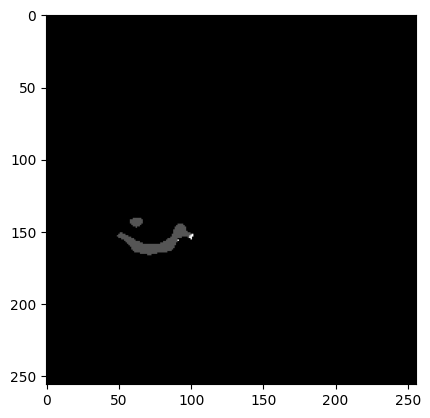

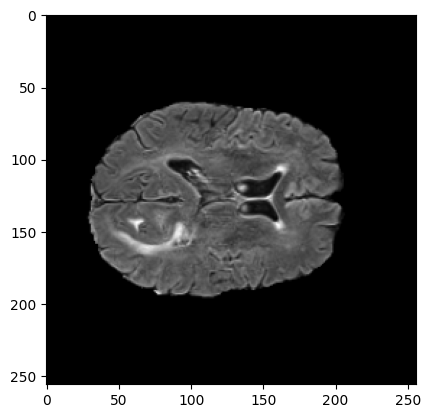

In [4]:
idx = 8
seg = pred[idx]

s = torch.zeros_like(seg[0])
s[seg[1] == 1] = 1
s[seg[2] == 1] = 2
s[seg[3] == 1] = 3

plt.imshow(s.cpu(), cmap='gray', vmax=3)
plt.show()

plt.imshow(img[idx][0].cpu(), cmap='gray')
plt.show()

# Equispaced

In [5]:
from src.mask_patterns import EquiSpacedMaskFunc

acc_facs = [8, 16, 32]

for a in acc_facs:
    mask = EquiSpacedMaskFunc([0.04], [a])((1, 256, 256))[0].cuda()
    mask = mask.squeeze(2).expand(256, -1)
    mask = mask.unsqueeze(0).unsqueeze(0)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            seg = batch['seg'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)

            pred = model(img_mag)

            pred = convert_brats_labels(torch.argmax(pred, dim=1).unsqueeze(1))
            seg = convert_brats_labels(seg)

            dice_metric(y_pred=pred, y=seg)
            iou_metric(y_pred=pred, y=seg)

    dice_res = dice_metric.aggregate()
    iou_res = iou_metric.aggregate()
    dice_res = torch.mean(dice_res, dim=0)
    iou_res = torch.mean(iou_res, dim=0)
    dice_metric.reset()
    iou_metric.reset()

    m = float(dice_res.mean(dim=0).cpu()), float(iou_res.mean(dim=0).cpu())
    r.update({'equi_' + str(a): m})

    print('Acc. Factor:', a)
    print('Dice Score:', m[0])
    print('IoU Score:', m[1])
    

Acc. Factor: 8
Dice Score: 0.6514235734939575
IoU Score: 0.5748015642166138
Acc. Factor: 16
Dice Score: 0.663716733455658
IoU Score: 0.5868129730224609
Acc. Factor: 32
Dice Score: 0.6624709963798523
IoU Score: 0.5854135751724243


## 2D Variable Density

In [4]:
from src.mask_patterns import get_2d_variable_density_mask

In [5]:
acc_facs = [8, 16, 32]

for a in acc_facs:
    
    for batch in dl:
            mask = get_2d_variable_density_mask(256, a, 25).cuda()
            mask = mask.unsqueeze(0).unsqueeze(0)

            img_k = batch['k_space'].cuda()
            seg = batch['seg'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)

            pred = model(img_mag)

            pred = convert_brats_labels(torch.argmax(pred, dim=1).unsqueeze(1))
            seg = convert_brats_labels(seg)

            dice_metric(y_pred=pred, y=seg)
            iou_metric(y_pred=pred, y=seg)

    dice_res = dice_metric.aggregate()
    iou_res = iou_metric.aggregate()
    dice_res = torch.mean(dice_res, dim=0)
    iou_res = torch.mean(iou_res, dim=0)
    dice_metric.reset()
    iou_metric.reset()

    m = float(dice_res.mean(dim=0).cpu()), float(iou_res.mean(dim=0).cpu())
    r.update({'var_dens_' + str(a): m})

    print('Acc. Factor:', a)
    print('Dice Score:', m[0])
    print('IoU Score:', m[1])

Acc. Factor: 8
Dice Score: 0.7643661499023438
IoU Score: 0.6987638473510742
Acc. Factor: 16
Dice Score: 0.4790206551551819
IoU Score: 0.4064818024635315
Acc. Factor: 32
Dice Score: 0.2451377809047699
IoU Score: 0.1799434870481491


## BERM 2D PROXY

In [8]:
result_dirs = ['brats_ensemble_proxy_8', 'brats_ensemble_proxy_16', 'brats_ensemble_proxy_32']
acc_facs = [8, 16, 32]
result_paths = [os.path.join('logs', d, 'results.pt') for d in result_dirs]
scores = [torch.load(f)['scores'][-1].cuda() for f in result_paths]

for score, d, a in zip(scores, result_dirs, acc_facs):
    mask = get_top_k_mask(score.squeeze(), a)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            seg = batch['seg'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)

            pred = model(img_mag)

            pred = convert_brats_labels(torch.argmax(pred, dim=1).unsqueeze(1))
            seg = convert_brats_labels(seg)

            dice_metric(y_pred=pred, y=seg)
            iou_metric(y_pred=pred, y=seg)

    dice_res = dice_metric.aggregate()
    iou_res = iou_metric.aggregate()
    dice_res = torch.mean(dice_res, dim=0)
    iou_res = torch.mean(iou_res, dim=0)
    dice_metric.reset()
    iou_metric.reset()

    m = float(dice_res.mean(dim=0).cpu()), float(iou_res.mean(dim=0).cpu())
    r.update({d: m})

    print('Run:', d)
    print('Dice Score:', m[0])
    print('IoU Score:', m[1])

Run: brats_ensemble_proxy_8
Dice Score: 0.7701048851013184
IoU Score: 0.7048425078392029
Run: brats_ensemble_proxy_16
Dice Score: 0.7696819305419922
IoU Score: 0.703723132610321
Run: brats_ensemble_proxy_32
Dice Score: 0.7554935216903687
IoU Score: 0.6864868998527527


## BERM 1D PROXY

In [9]:
result_dirs = ['brats_ensemble_proxy_1d_8', 'brats_ensemble_proxy_1d_16', 'brats_ensemble_proxy_1d_32']
acc_facs = [8, 16, 32]
result_paths = [os.path.join('logs', d, 'results.pt') for d in result_dirs]
scores = [torch.load(f)['scores'][-1].cuda() for f in result_paths]

for score, d, a in zip(scores, result_dirs, acc_facs):
    mask = get_top_k_mask(score.squeeze(), a)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            seg = batch['seg'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)

            pred = model(img_mag)

            pred = convert_brats_labels(torch.argmax(pred, dim=1).unsqueeze(1))
            seg = convert_brats_labels(seg)

            dice_metric(y_pred=pred, y=seg)
            iou_metric(y_pred=pred, y=seg)

    dice_res = dice_metric.aggregate()
    iou_res = iou_metric.aggregate()
    dice_res = torch.mean(dice_res, dim=0)
    iou_res = torch.mean(iou_res, dim=0)
    dice_metric.reset()
    iou_metric.reset()

    m = float(dice_res.mean(dim=0).cpu()), float(iou_res.mean(dim=0).cpu())
    r.update({d: m})

    print('Run:', d)
    print('Dice Score:', m[0])
    print('IoU Score:', m[1])

Run: brats_ensemble_proxy_1d_8
Dice Score: 0.7615079879760742
IoU Score: 0.6932235956192017
Run: brats_ensemble_proxy_1d_16
Dice Score: 0.6150884628295898
IoU Score: 0.5365227460861206
Run: brats_ensemble_proxy_1d_32
Dice Score: 0.5965697765350342
IoU Score: 0.5189796686172485


# IGS Sampling

In [10]:
from src.igs import IGS

masks = torch.load('logs/IGS/igs_brats_seg.pt').cuda()

acc_facs = [8, 16, 32]
ns = [IGS.get_n(acc_fac=a, img_size=256) for a in acc_facs]

for n, a in zip(ns, acc_facs):
    mask = masks[n - 2].unsqueeze(0)
    mask = mask.expand(256, -1)
    mask = mask.unsqueeze(0).unsqueeze(0)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            seg = batch['seg'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)

            pred = model(img_mag)

            pred = convert_brats_labels(torch.argmax(pred, dim=1).unsqueeze(1))
            seg = convert_brats_labels(seg)

            dice_metric(y_pred=pred, y=seg)
            iou_metric(y_pred=pred, y=seg)

    dice_res = dice_metric.aggregate()
    iou_res = iou_metric.aggregate()
    dice_res = torch.mean(dice_res, dim=0)
    iou_res = torch.mean(iou_res, dim=0)
    dice_metric.reset()
    iou_metric.reset()

    m = float(dice_res.mean(dim=0).cpu()), float(iou_res.mean(dim=0).cpu())
    r.update({'igs_proxy' + str(a): m})

    print('Acc. Factor:', a)
    print('Dice Score:', m[0])
    print('IoU Score:', m[1])
    

Acc. Factor: 8
Dice Score: 0.7614902853965759
IoU Score: 0.6933718919754028
Acc. Factor: 16
Dice Score: 0.718333899974823
IoU Score: 0.6440576910972595
Acc. Factor: 32
Dice Score: 0.6344519853591919
IoU Score: 0.5566534399986267


In [11]:
r

{'full': (0.7716304063796997, 0.7063905596733093),
 'equi_8': (0.6514235734939575, 0.5748015642166138),
 'equi_16': (0.663716733455658, 0.5868129730224609),
 'equi_32': (0.6624709963798523, 0.5854135751724243),
 'var_dens_8': (0.424396276473999, 0.3493199348449707),
 'var_dens_16': (0.3133835196495056, 0.23685422539710999),
 'var_dens_32': (0.21508824825286865, 0.15093521773815155),
 'brats_ensemble_proxy_8': (0.7701048851013184, 0.7048425078392029),
 'brats_ensemble_proxy_16': (0.7696819305419922, 0.703723132610321),
 'brats_ensemble_proxy_32': (0.7554935216903687, 0.6864868998527527),
 'brats_ensemble_proxy_1d_8': (0.7615079879760742, 0.6932235956192017),
 'brats_ensemble_proxy_1d_16': (0.6150884628295898, 0.5365227460861206),
 'brats_ensemble_proxy_1d_32': (0.5965697765350342, 0.5189796686172485),
 'igs_proxy8': (0.7614902853965759, 0.6933718919754028),
 'igs_proxy16': (0.718333899974823, 0.6440576910972595),
 'igs_proxy32': (0.6344519853591919, 0.5566534399986267)}